In [1]:
import sys
import argparse
import configparser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from scipy.spatial.distance import cdist
from metadata.const import features, dtypes, class_label

In [2]:
def get_config(section):
    config = configparser.RawConfigParser()
    config.read('../settings.ini')
    return dict(config.items(section))

In [3]:
def get_box_whisker_range(df):
    q1 = df.quantile(q=0.25)
    q3 = df.quantile(q=0.75)
    iqr = q3 - q1
    min_range = q1 - 1.5 * iqr
    max_range = q3 + 1.5 * iqr

    return min_range, max_range

In [4]:
def remove_zero_variance(df):
    const_filter = VarianceThreshold()
    const_filter.fit(df)
    cols = const_filter.get_support(indices=True)
    return df.iloc[:, cols]

In [5]:
def plot_correlation(correlation, filename, save=True, labels=None):
    fig = plt.figure(figsize=(10.41, 7.29))
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlation, vmin=-1, vmax=1)
    fig.colorbar(cax)
    if labels:
        ticks = np.arange(0, len(labels), 1)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)

        plt.setp(ax.get_xticklabels(), rotation=45, ha="left",
                rotation_mode="anchor")
    if save:
        plt.savefig(filename)
    else:
        plt.show()

In [6]:
filename = 'niloo-dataset.csv'
df = pd.read_csv(f'../dataset/{filename}', dtype=dtypes, low_memory=True)
df.drop(
    [
        features['unnamed0'],
        features['flow_id'],
        features['source_ip'],
        features['source_port'],
        features['destination_ip'],
        features['destination_port'],
        features['timestamp'],
#         features['similar_http'],
        features['protocol'],
        features['inbound']
    ],
    axis=1,
    inplace=True
)

In [7]:
df.describe()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,1.960500e+04,19605.000000,19605.000000,19605.000000,1.960500e+04,19605.000000,19605.000000,19605.000000,19605.000000,19605.000000,...,1.960500e+04,1.960500e+04,1.960500e+04,1.960500e+04,1.960500e+04,1.960500e+04,1.960500e+04,1.960500e+04,19605.0,19605.000000
mean,6.239214e+06,5.774598,4.823412,928.839783,3.659619e+03,290.428558,215.282639,230.695847,24.508892,146.655548,...,1.361622e+08,5.168891e+04,2.289987e+04,7.921046e+04,3.744815e+04,2.357688e+06,2.343408e+05,2.580800e+06,2157393.5,0.497169
std,2.348872e+07,25.516342,41.273931,3012.684814,6.642376e+04,443.534821,355.898376,353.969208,98.042755,538.466919,...,7.041754e+08,4.170448e+05,2.229945e+05,5.845965e+05,3.825086e+05,1.014565e+07,2.068752e+06,1.083784e+07,9788354.0,0.500005
min,1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000
25%,1.000000e+00,2.000000,0.000000,12.000000,0.000000e+00,6.000000,6.000000,6.000000,0.000000,0.000000,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000
50%,5.400000e+01,2.000000,0.000000,102.000000,0.000000e+00,46.000000,32.000000,43.000000,0.000000,0.000000,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000
75%,3.834600e+04,2.000000,2.000000,944.000000,2.400000e+01,412.000000,330.000000,359.500000,0.000000,6.000000,...,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.000000
max,1.199782e+08,1302.000000,2384.000000,150726.000000,4.068626e+06,3620.000000,1791.000000,1791.000000,1243.786011,3577.000000,...,4.294967e+09,1.103203e+07,7.914871e+06,1.560456e+07,1.103203e+07,1.119934e+08,6.188006e+07,1.119934e+08,111993448.0,1.000000


In [8]:
for col in df.select_dtypes(exclude='category').columns.tolist():
    df.loc[df[col] < 0, col] = np.nan

In [9]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [10]:
print(df.isna().sum().sort_values(ascending=False))
df = df.drop([features['flow_packets_s'], features['flow_bytes_s']], axis=1)

 Flow Duration         0
Subflow Fwd Packets    0
 Max Packet Length     0
 Packet Length Mean    0
 Packet Length Std     0
                      ..
 Bwd IAT Max           0
 Bwd IAT Min           0
Fwd PSH Flags          0
 Fwd Header Length     0
 Label                 0
Length: 66, dtype: int64


In [11]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [12]:
X = df.drop(class_label, axis=1)
y = df[class_label]

In [13]:
columns = set(X.columns)
X = remove_zero_variance(X)
print(columns - set(X.columns))

set()


In [14]:
numeric_X = X.select_dtypes(exclude='category')
corr_matrix = numeric_X.corr(method='pearson')

In [15]:
redundent_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            redundent_features.add(corr_matrix.columns[i])

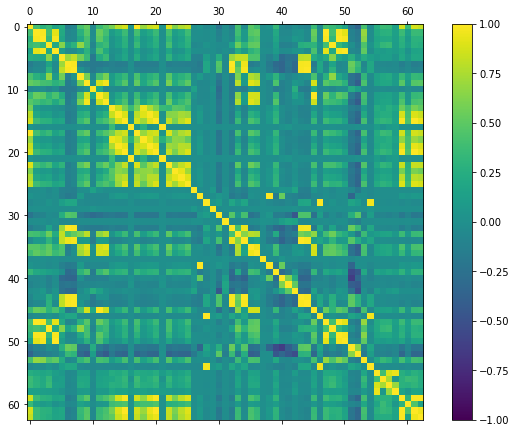

In [16]:
plot_correlation(
    corr_matrix,
    'numeric-correlation.png',
    save=False
#     labels=numeric_X.columns.to_list()
)

In [17]:
print(redundent_features)
X.drop(list(redundent_features), axis=1, inplace=True)

{'Bwd IAT Total', ' Avg Bwd Segment Size', ' Total Backward Packets', ' Bwd Packet Length Mean', ' Flow IAT Max', ' RST Flag Count', ' Avg Fwd Segment Size', 'Idle Mean', 'Subflow Fwd Packets', 'Fwd IAT Total', ' Active Min', ' Flow IAT Std', ' Packet Length Mean', ' Fwd IAT Std', ' Fwd Packet Length Mean', ' Subflow Fwd Bytes', ' Bwd IAT Std', ' Idle Min', ' Bwd Packet Length Std', ' Bwd IAT Max', ' Fwd IAT Min', ' Fwd IAT Mean', ' Packet Length Std', ' Fwd Header Length.1', ' Min Packet Length', ' Packet Length Variance', ' Average Packet Size', ' Fwd IAT Max', ' Active Max', ' Total Length of Bwd Packets', ' Subflow Bwd Packets', ' min_seg_size_forward', ' Subflow Bwd Bytes', ' Max Packet Length', ' Idle Max'}


In [18]:
scale = StandardScaler()
X_norm = scale.fit_transform(X)
print(X_norm.shape)

(19605, 28)


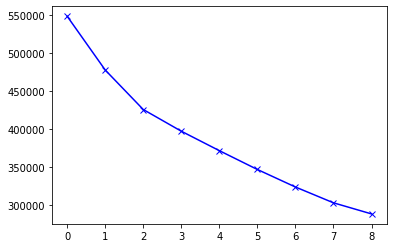

In [19]:
cost = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_norm)
    cost.append(kmeans.inertia_)
plt.plot(cost, 'bx-')

In [20]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_norm)
kmeans_labels = kmeans.labels_

In [21]:
pca = PCA(2)
pca.fit(X_norm)
X_PCA = pca.transform(X_norm)
X_PCA.shape

(19605, 2)

In [22]:
x_pca, y_pca = X_PCA[:, 0], X_PCA[:, 1]
colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow',
          4: 'orange',
          5: 'purple',
          6: 'pink',
          7: 'gray',
          8: 'brown'}
pca_df = pd.DataFrame({'x': x_pca, 'y': y_pca, 'label': kmeans_labels})
groups = pca_df.groupby('label')

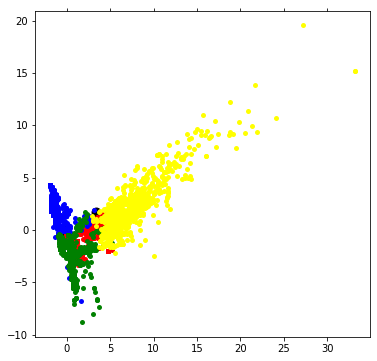

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, color='black')
plt.show()

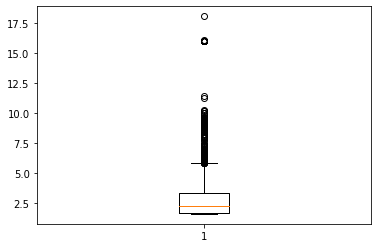

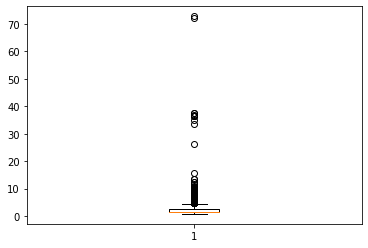

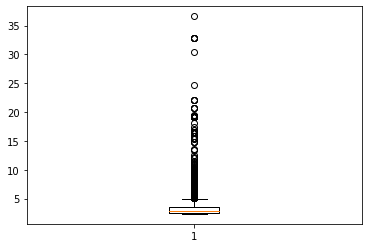

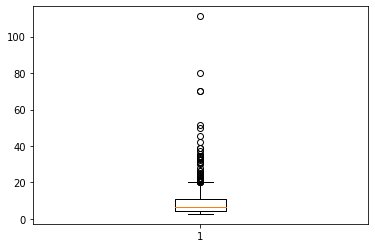

In [24]:
outliers = []
for i, center in enumerate(centroids):
    distances = cdist([center], X_norm[kmeans_labels == i], 'euclidean').ravel()
    truthness = (kmeans_labels == i)
    indices = []
    for j in range(len(truthness)):
        if truthness[j]:
            indices.append(j)
    min_range, max_range = get_box_whisker_range(pd.DataFrame({'distance': pd.Series(distances)}))
    min_range = min_range['distance']
    max_range = max_range['distance']
    for i in range(len(indices)):
        if distances[i] > max_range or distances[i] < min_range:
            outliers.append(indices[i])
    plt.boxplot(distances.tolist())
    plt.show()

In [25]:
print(len(outliers))
X.drop(outliers, axis=0, inplace=True)
y.drop(outliers, axis=0, inplace=True)

1313


In [26]:
df = pd.concat([X, y], axis=1)

In [27]:
df.to_csv(f'../dataset/clean-{filename}', index=False)